# 라이브러리 로딩

In [1]:
import numpy as np # Numpy
import pandas as pd # Pandas
import matplotlib as mpl #Matplotlib 세팅용
import matplotlib.pyplot as plt # 시각화 도구
import seaborn as sns # 시각화 도구
from sklearn.model_selection import train_test_split # 데이터셋 분리
from sklearn.model_selection import KFold # KFold 교차검증
from sklearn.cluster import KMeans # 클러스터링
from sklearn.metrics import silhouette_score # 실루엣 점수
import xgboost as xgb # XGBoost
from sklearn.model_selection import GridSearchCV # 그리드 서치
from sklearn.metrics import accuracy_score, precision_score # 평가 지표
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score, f1_score # 평가 지표
from imblearn.combine import SMOTEENN, SMOTETomek # 복합샘플링
from hyperopt import hp, fmin, tpe, Trials # HyperOPT

import warnings # 경고문 제거용


%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

# 한글 폰트 설정
mpl.rc('font', family='D2Coding')
# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus = False)

warnings.filterwarnings('ignore')
sns.set(font="D2Coding", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc('figure', figsize=(10,8))

# 데이터 불러오기

In [2]:
data = pd.read_excel('train_test_na_filled.xlsx', sheet_name='Train')

# 데이터 탐색

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin1        8590 non-null   object 
 4   Cabin2        8590 non-null   float64
 5   Combi         8590 non-null   object 
 6   Cabin3        8590 non-null   object 
 7   Cabin         8590 non-null   object 
 8   Destination   8693 non-null   object 
 9   Age           8693 non-null   int64  
 10  VIP           8693 non-null   bool   
 11  RoomService   8693 non-null   int64  
 12  FoodCourt     8693 non-null   int64  
 13  ShoppingMall  8693 non-null   int64  
 14  Spa           8693 non-null   int64  
 15  VRDeck        8693 non-null   int64  
 16  Name          8493 non-null   object 
 17  Transported   8693 non-null   bool   
dtypes: bool(3), float64(1), int6

In [4]:
data.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin1          103
Cabin2          103
Combi           103
Cabin3          103
Cabin           103
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [5]:
# 필요없는 features 제거
data.drop(['PassengerId', 'Cabin', 'Combi', 'Name',], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin1        8590 non-null   object 
 3   Cabin2        8590 non-null   float64
 4   Cabin3        8590 non-null   object 
 5   Destination   8693 non-null   object 
 6   Age           8693 non-null   int64  
 7   VIP           8693 non-null   bool   
 8   RoomService   8693 non-null   int64  
 9   FoodCourt     8693 non-null   int64  
 10  ShoppingMall  8693 non-null   int64  
 11  Spa           8693 non-null   int64  
 12  VRDeck        8693 non-null   int64  
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(1), int64(6), object(4)
memory usage: 772.6+ KB


In [7]:
# 결측값들 제거(Cabin)
data.dropna(axis=0, inplace=True)

In [8]:
data.isna().sum()

HomePlanet      0
CryoSleep       0
Cabin1          0
Cabin2          0
Cabin3          0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [9]:
data['Cabin3'].replace({'P': True,'S': False}, inplace=True)
data['Cabin3'] = data['Cabin3'].astype(bool)

In [10]:
train_encoding = pd.get_dummies(data['HomePlanet'])
data=data.drop('HomePlanet',axis=1)
data = data.join(train_encoding)

train_encoding = pd.get_dummies(data['Destination'])
data=data.drop('Destination',axis=1)
data = data.join(train_encoding)

train_encoding = pd.get_dummies(data['Cabin1'])
data=data.drop('Cabin1',axis=1)
data = data.join(train_encoding)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8590 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CryoSleep      8590 non-null   bool   
 1   Cabin2         8590 non-null   float64
 2   Cabin3         8590 non-null   bool   
 3   Age            8590 non-null   int64  
 4   VIP            8590 non-null   bool   
 5   RoomService    8590 non-null   int64  
 6   FoodCourt      8590 non-null   int64  
 7   ShoppingMall   8590 non-null   int64  
 8   Spa            8590 non-null   int64  
 9   VRDeck         8590 non-null   int64  
 10  Transported    8590 non-null   bool   
 11  Earth          8590 non-null   uint8  
 12  Europa         8590 non-null   uint8  
 13  Mars           8590 non-null   uint8  
 14  55 Cancri e    8590 non-null   uint8  
 15  PSO J318.5-22  8590 non-null   uint8  
 16  TRAPPIST-1e    8590 non-null   uint8  
 17  A              8590 non-null   uint8  
 18  B       

In [12]:
col = ['Cabin2', 'Age', 'RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
def data_scaled(df, col):
    for i in col:
        data_mean = df[i].mean()
        data_std = df[i].std()
        scaled = (df[i]-data_mean)/data_std
        df[i]=scaled
    return df

In [13]:
data_scaled(data, col)

,CryoSleep,Cabin2,Cabin3,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,PSO J318.5-22,TRAPPIST-1e,A,B,C,D,E,F,G,T
0,False,-1.170228,True,0.712274,False,-0.333743,-0.280785,-0.282832,-0.271469,-0.263361,...,0,1,0,1,0,0,0,0,0,0
1,False,-1.170228,False,-0.332624,False,-0.168530,-0.275148,-0.241196,0.220460,-0.224520,...,0,1,0,0,0,0,0,1,0,0
2,False,-1.170228,False,2.035811,True,-0.268567,1.959032,-0.282832,5.745469,-0.220106,...,0,1,1,0,0,0,0,0,0,0
3,False,-1.170228,False,0.294315,False,-0.333743,0.522818,0.335048,2.711463,-0.092988,...,0,1,1,0,0,0,0,0,0,0
4,False,-1.168274,False,-0.889902,False,0.125518,-0.236941,-0.031350,0.234796,-0.261596,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,-0.978724,True,0.851594,True,-0.333743,3.990274,-0.282832,1.200732,-0.198037,...,0,0,1,0,0,0,0,0,0,0
8689,True,1.758999,False,-0.750583,False,-0.333743,-0.280785,-0.282832,-0.271469,-0.263361,...,1,0,0,0,0,0,0,0,1,0
8690,False,1.760953,False,-0.193304,False,-0.333743,-0.280785,2.834877,-0.270573,-0.263361,...,0,1,0,0,0,0,0,0,1,0
8691,False,0.017878,False,0.224655,False,-0.333743,0.376253,-0.282832,0.044835,2.592370,...,0,0,0,0,0,0,1,0,0,0


## 상관계수

In [14]:
data.corrwith(data.Transported, method='spearman').sort_values(ascending=False)

Transported      1.000000
CryoSleep        0.460021
Europa           0.180744
B                0.145726
C                0.109910
55 Cancri e      0.106853
Mars             0.021006
G                0.014997
A               -0.000215
PSO J318.5-22   -0.001317
T               -0.014694
D               -0.034417
VIP             -0.042770
Cabin2          -0.048462
Age             -0.070738
F               -0.090295
TRAPPIST-1e     -0.093785
E               -0.097682
Cabin3          -0.103993
Earth           -0.174332
FoodCourt       -0.186012
ShoppingMall    -0.227211
VRDeck          -0.346649
RoomService     -0.364049
Spa             -0.366036
dtype: float64

## 다중공선성

### OLS(Ordinary Least Squares)

In [15]:
data.columns

Index(['CryoSleep', 'Cabin2', 'Cabin3', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Earth',
       'Europa', 'Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'T'],
      dtype='object')

In [16]:
df = data.iloc[:,:]

In [17]:
df['Transported'] = df.Transported.replace({True:1, False:0})

In [18]:
from statsmodels.formula.api import ols

X = df.drop('Transported', axis=1)
y = df.Transported

model = ols('Transported ~ CryoSleep + Cabin2 + Cabin3 + Age + VIP + RoomService + FoodCourt +\
ShoppingMall + Spa + VRDeck + Earth + Europa + Mars + A + B + C + D + E + F + G + T', df)

res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transported   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     251.4
Date:                Thu, 24 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:49:54   Log-Likelihood:                -4331.3
No. Observations:                8590   AIC:                             8703.
Df Residuals:                    8570   BIC:                             8844.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2974      0.017     17.474      0.000       0.264       0.331
CryoSleep[T.True]     0.3781      0.012     32.602      0.000       0.355       0.401
Cabin3[T.True]       -0.0866      0.009     -9.986      0.000      -0.104      -0.070
VIP[T.True]          -0.0469      0.029     -1.625      0.104      -0.104       0.010
Cabin2                0.0164      0.006      2.917      0.004       0.005       0.027
Age                  -0.0350      0.005     -7.744      0.000      -0.044      -0.026
RoomService          -0.0780      0.005    -16.619      0.000      -0.087      -0.069
FoodCourt             0.0685      0.005     13.990      0.000       0.059       0.078
ShoppingMall          0.0470      0.004     10.486      0.000       0.038       0.056
Spa                  -0.0979      0.005    -21.029      0.000      -0.107      -0.089
VRDeck               -0.0942      0.005    -20.036      0.000      -0.103      -0.085
Earth                -0.0232      0.014     -1.611      0.107      -0.051       0.005
Europa                0.2362      0.018     13.129      0.000       0.201       0.271
Mars                  0.0843      0.013      6.308      0.000       0.058       0.111
A                    -0.0220      0.033     -0.669      0.503      -0.087       0.042
B                     0.0898      0.027      3.279      0.001       0.036       0.143
C                     0.1232      0.028      4.475      0.000       0.069       0.177
D                     0.0339      0.027      1.247      0.212      -0.019       0.087
E                    -0.0085      0.026     -0.322      0.748      -0.060       0.043
F                     0.0726      0.027      2.656      0.008       0.019       0.126
G                     0.0383      0.029      1.331      0.183      -0.018       0.095
T                    -0.0299      0.160     -0.187      0.851      -0.343       0.283
==============================================================================
Omnibus:                      597.313   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.163
Skew:                           0.172   Prob(JB):                     7.07e-53
Kurtosis:                       2.257   Cond. No.                     1.67e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.65e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
model.exog_names

['Intercept',
 'CryoSleep[T.True]',
 'Cabin3[T.True]',
 'VIP[T.True]',
 'Cabin2',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Earth',
 'Europa',
 'Mars',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'T']

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,CryoSleep[T.True],1.631634
1,Cabin3[T.True],1.003878
2,VIP[T.True],1.068126
3,Cabin2,1.681615
4,Age,1.089588
5,RoomService,1.175189
6,FoodCourt,1.278511
7,ShoppingMall,1.073501
8,Spa,1.157895
9,VRDeck,1.178994


In [21]:
data.Transported.value_counts()

1    4333
0    4257
Name: Transported, dtype: int64

In [22]:
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

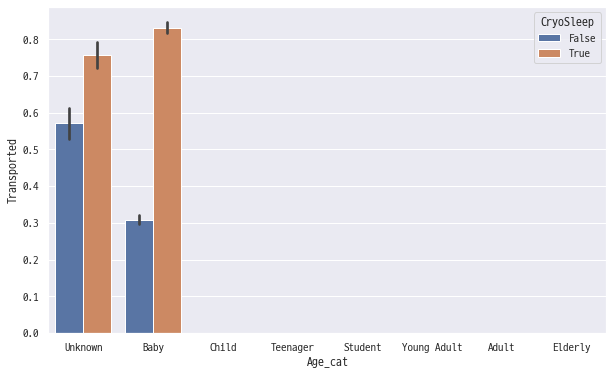

In [23]:
plt. figure(figsize=(10, 6))

group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']
data['Age_cat'] = data['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Transported', hue='CryoSleep', data=data, order=group_names)
data.drop('Age_cat', axis=1, inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Transported'], axis=1),
                                                    df.Transported, random_state=109)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [25]:
X_train.shape

(4831, 24)

In [26]:
y_train.shape

(4831,)

In [27]:
y_train.value_counts()

1    2464
0    2367
Name: Transported, dtype: int64

In [28]:
# xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
#                    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
#                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
#                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.4),
#                    'gamma': hp.uniform('gamma', 0, 4)}

In [29]:
# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환
def bin_objective_func(search_space):
    xgb_clf = xgb.XGBClassifier(n_estimators=100,max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            gamma=search_space['gamma'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits=3)
    
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOPT는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1*np.mean(roc_auc_list)

In [30]:
# trials = Trials()

# # fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
# best = fmin(fn=bin_objective_func,
#            space=xgb_search_space,
#            algo=tpe.suggest,
#            max_evals=50, # 최대 반복 횟수를 지정합니다
#            trials=trials, rstate=np.random.default_rng(seed=109))

# print('best:', best)

In [31]:
xgbo = xgb.XGBClassifier(colsample_bytree=0.708890925020427, gamma=2.039476183481736,
                         learning_rate=0.16202345555142844,
                         max_depth=10, min_child_weight=6, n_estimators=100,
                         random_state=109)
xgbo.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.708890925020427, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.039476183481736, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.16202345555142844, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=109, ...)

In [32]:
# 평가용 함수
def  get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
#     roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
 
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, \
    재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [33]:
train_pred = xgbo.predict(X_train)
train_proba = xgbo.predict_proba(X_train)

test_pred = xgbo.predict(X_test)
test_proba = xgbo.predict_proba(X_test)

val_pred = xgbo.predict(X_val)
val_proba = xgbo.predict_proba(X_val)

In [34]:
get_clf_eval(y_train, train_pred, train_proba)

오차 행렬
[[2109  258]
 [ 252 2212]]
정확도: 0.8944, 정밀도: 0.8955,     재현율: 0.8977, F1: 0.8966


In [35]:
get_clf_eval(y_test, test_pred, test_proba)

오차 행렬
[[849 218]
 [218 863]]
정확도: 0.7970, 정밀도: 0.7983,     재현율: 0.7983, F1: 0.7983


In [36]:
get_clf_eval(y_val, val_pred, val_proba)

오차 행렬
[[667 156]
 [155 633]]
정확도: 0.8070, 정밀도: 0.8023,     재현율: 0.8033, F1: 0.8028


In [48]:
xgbo.feature_importances_.shape

(24,)

In [51]:
fi = pd.DataFrame(xgbo.feature_importances_, index=X_train.columns)

In [52]:
fi

,0
CryoSleep,0.404858
Cabin2,0.013693
Cabin3,0.024119
Age,0.013701
VIP,0.002429
RoomService,0.043292
FoodCourt,0.032967
ShoppingMall,0.022653
Spa,0.040408
VRDeck,0.031387
